In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Using cpu device


# Convolutional autoencoder

get a sence of how complex our model should be

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 50):
            super(Encoder, self).__init__()
            self.latent_dim = latent_dim

            encoder_channels = [input_channels] + encoder_channels
            self.encoder_channels = encoder_channels

            self.conv_layers = nn.ModuleList()
            for i in range(len(encoder_channels)-1):
                self.conv_layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=2))
                self.conv_layers.append(nn.BatchNorm2d(encoder_channels[i+1]))
                self.conv_layers.append(nn.ReLU())

            self.flatten = nn.Flatten()
            self.fc = nn.Linear(10000, self.latent_dim) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x

class Decoder(nn.Module):
    def __init__(self, enc_channels, latent_dim, enc_conv_shape):
        super(Decoder, self).__init__()
        self.decoder_channels = enc_channels[::-1]

        self.fc = nn.Linear(latent_dim, enc_conv_shape[0]*enc_conv_shape[1]*enc_conv_shape[2])
        self.unflatten = nn.Unflatten(1, enc_conv_shape)

        self.fc2 = nn.Linear(28*28*1, 28*28*1) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


        self.deconv_layers = nn.ModuleList()
        for i in range(len(self.decoder_channels)-1):
            self.deconv_layers.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i+1], kernel_size=2))
            self.deconv_layers.append(nn.BatchNorm2d(self.decoder_channels[i+1]))
            self.deconv_layers.append(nn.ReLU())



    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)

        for layer in self.deconv_layers:
            x = layer(x)

        x = x.flatten(1)

        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        x = x.view(-1, 1, 28, 28)
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 100):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(input_channels, encoder_channels, latent_dim = latent_dim)
        latent_dim = latent_dim
        output_conv_shape = torch.Size([encoder_channels[-1], 25, 25])
        encoder_channels = [input_channels] + encoder_channels
        self.decoder = Decoder(encoder_channels, latent_dim, output_conv_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
import torchvision
batch_size = 128

dataloader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=batch_size,
        shuffle=True)

torch.Size([128, 1, 28, 28])


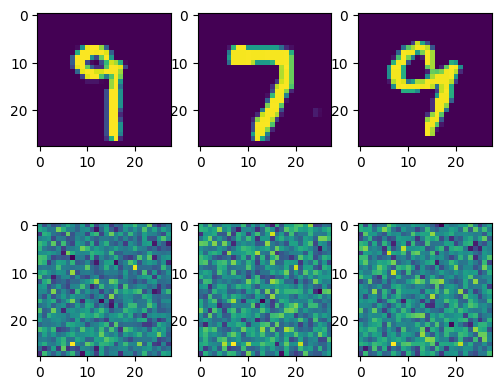

In [16]:

# Define model parameters
input_channels = 1
encoder_channels = [4, 8, 16]    #shpuld be like 8,16,32 ...
latent_dim = 20

model_autoencoder = ConvAutoencoder(input_channels, encoder_channels, latent_dim)
criterion = nn.MSELoss()

model_autoencoder = model_autoencoder.to(device)
criterion = criterion.to(device)


random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model_autoencoder(random_batch)

print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [ ]:
# Training loop
optimizer = optim.Adam(model_autoencoder.parameters(), lr=1e-3)

num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model_autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}")


torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28])


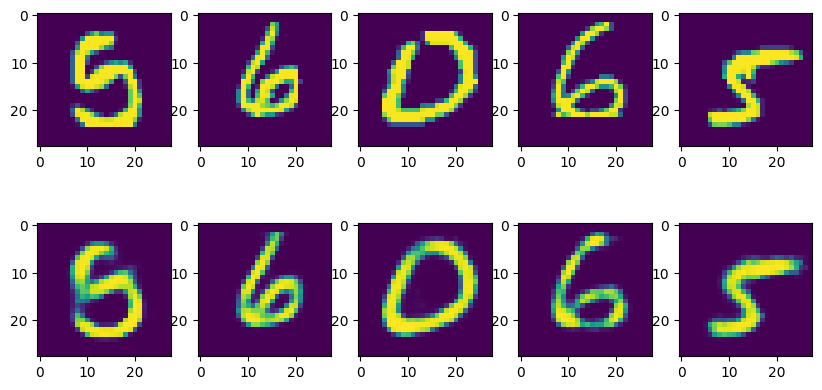

In [23]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model_autoencoder(random_batch)
print(output.shape, random_batch.shape)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


looks good enough for ~5 min training time on Colab T4

# Variational autoencoder variant

In [24]:
class VAE_Encoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 50):
        super(VAE_Encoder, self).__init__()
        self.latent_dim = latent_dim

        encoder_channels = [input_channels] + encoder_channels
        self.encoder_channels = encoder_channels

        self.conv_layers = nn.ModuleList()
        for i in range(len(encoder_channels)-1):
            self.conv_layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=2))
            self.conv_layers.append(nn.BatchNorm2d(encoder_channels[i+1]))
            self.conv_layers.append(nn.ReLU())

        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(10000, latent_dim)
        self.fc_logvar = nn.Linear(10000, latent_dim)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = self.flatten(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar


class VAE_Decoder(nn.Module):
    def __init__(self, enc_channels, latent_dim, enc_conv_shape):
        super(VAE_Decoder, self).__init__()
        self.decoder_channels = enc_channels[::-1]

        self.fc = nn.Linear(latent_dim, enc_conv_shape[0]*enc_conv_shape[1]*enc_conv_shape[2])
        self.unflatten = nn.Unflatten(1, enc_conv_shape)

        self.fc2 = nn.Linear(1*28*28, 1*28*28) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


        self.deconv_layers = nn.ModuleList()
        for i in range(len(self.decoder_channels)-1):
            self.deconv_layers.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i+1], kernel_size=2))
            self.deconv_layers.append(nn.BatchNorm2d(self.decoder_channels[i+1]))
            self.deconv_layers.append(nn.ReLU())



    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)

        for layer in self.deconv_layers:
            x = layer(x)

        x = x.flatten(1)

        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        x = x.view(-1, 1, 28, 28)
        return x



class VAE(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 100):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(input_channels, encoder_channels, latent_dim = latent_dim)
        latent_dim = latent_dim
        output_conv_shape = torch.Size([encoder_channels[-1], 25, 25])
        encoder_channels = [input_channels] + encoder_channels
        self.decoder = VAE_Decoder(encoder_channels, latent_dim, output_conv_shape)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) # e^[0.5*logvar] = sqrt(e^logvar) = sqrt(var)
        eps = torch.randn_like(std) #torch.randn_like(std) returns a tensor with the same size as std with values sampled from N(0,1)
        z = mu + eps*std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar #return mu, logvar for KL divergence calculation, and X for reconstruction loss



In [25]:
def loss_function(criterion, recon_x, x, mu, logvar, KL_weight = 1.0):
    MSE = criterion(recon_x, x) #used to define nn.MSELoss() right here in the function, which is probably not the best idea
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    SUM = MSE + KL_weight*KLD
    return SUM


In [26]:
batch_size = 128

dataloader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=batch_size,
        shuffle=True)

torch.Size([128, 1, 28, 28])


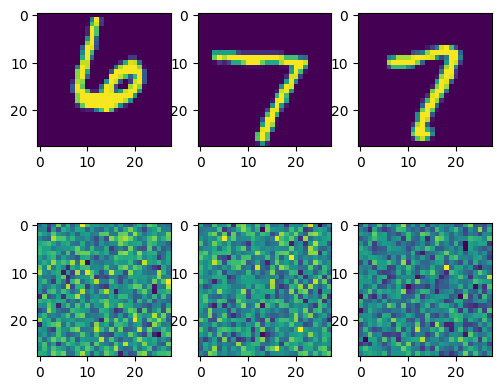

In [27]:
input_channels = 1  # RGB channels
encoder_channels = [4, 8, 16]    #shpuld be like 8,16,32 ...
latent_dim = 20


model_vae = VAE(input_channels, encoder_channels, latent_dim)
criterion = nn.MSELoss()

model_vae = model_vae.to(device)


random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output_all = model_vae(random_batch)
output = output_all[0]


print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [32]:
optimizer = optim.Adam(model_vae.parameters(), lr=5e-4)


In [33]:
num_epochs = 5
KL_weight = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    running_KL = 0.0
    running_recon = 0.0

    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model_vae(images)
        recon_x = outputs[0]
        mu = outputs[1]
        logvar = outputs[2]
        loss = loss_function(criterion = criterion, recon_x=recon_x, x = images, mu = mu, logvar = logvar, KL_weight = KL_weight)
        loss.backward()
        optimizer.step()

        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        recon = loss - KL*KL_weight

        running_KL += KL.item() * images.size(0)
        running_recon += recon.item() * images.size(0)
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_KL = running_KL / len(dataloader.dataset)
    epoch_recon = running_recon / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, KL: {epoch_KL:.5f}, Recon: {epoch_recon:.5f}")



Epoch [1/5], Loss: 34.22302, KL: 34.15549, Recon: 0.06752
Epoch [2/5], Loss: 1.75715, KL: 1.68975, Recon: 0.06740
Epoch [3/5], Loss: 1.54918, KL: 1.48183, Recon: 0.06735
Epoch [4/5], Loss: 1.88206, KL: 1.81473, Recon: 0.06733
Epoch [5/5], Loss: 2.17835, KL: 2.11103, Recon: 0.06732


loss_vae=0.06550 ; loss_autoencoder=0.00870


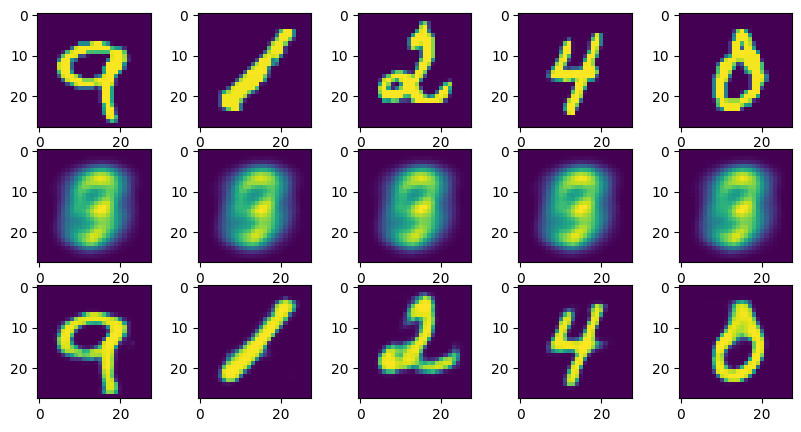

In [34]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model_vae(random_batch)[0]
output_autoencoder = model_autoencoder(random_batch)

loss_vae = criterion(random_batch, output)
loss_autoencoder = criterion(output_autoencoder, random_batch)

print(f'{loss_vae=:.5f} ; {loss_autoencoder=:.5f}')

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(3, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(3, 5, i+11)
    plt.imshow(output_autoencoder[i].permute(1, 2, 0).cpu().detach().numpy())


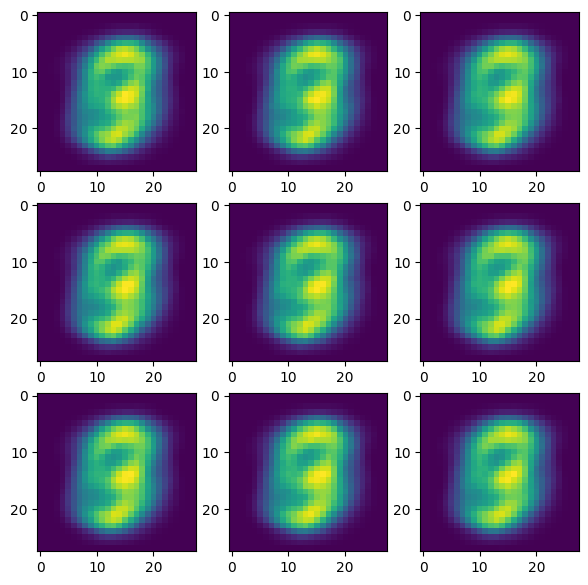

In [37]:
#sampling from the latent space
n = 9 
z = torch.randn(n, latent_dim).to(device)
output = model_vae.decoder(z)

plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    #plt.title(f'z: {z.detach().cpu().numpy().round(2)}')
